# Set-up and Installing of Dependencies

In [ ]:
# Installing required packages
%pip install tableone
%pip install shap

# Importing dependencies for this notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import shap
from tableone import TableOne
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.utils import resample
from xgboost import XGBClassifier
import pickle

#Configurations
warnings.filterwarnings(action='ignore')
filepath = "./data/catB_train.parquet"

# Analysis

## 1.0 Dataset Cleaning

In [ ]:
# Opening the train dataset
df = pd.read_parquet(filepath)

# Replacing all missing data as NaN (some are encoded as None)
df = df.fillna(value = np.nan)
display(df)

## 1.1 Dropping rows and columns

In [ ]:
# Replacing NAs in target column with 0 so they don't accidentally get dropped
df['f_purchase_lh'] = df['f_purchase_lh'].fillna(0)

In [ ]:
# Dropping columns where more than half the values are NA
null_thresh = 0.5 * len(df)
col_dropped = df.columns[df.isna().sum() >= null_thresh]
df = df.dropna(axis=1, thresh = null_thresh)

print("A total of",304-df.shape[1],"columns dropped. Columns dropped are", list(col_dropped),"\n")
print(f"The current shape of the df is as follows: {df.shape}")

In [ ]:
# Dropping columns with only one unique value (they add nothing to the model)
col_no = df.shape[1]

columns_to_drop = df.columns[df.nunique() == 1]
df = df.drop(columns = columns_to_drop)

print("A total of", col_no - df.shape[1],"columns dropped. Columns dropped are", columns_to_drop,"\n")
print(f"The current shape of the df is as follows: {df.shape}")

In [ ]:
# Dropping race as well due to ethical and social implications of using race to drive actions;
# also since chinese are the majority @ 58.5% and NaN making up 22.2% with the rest <10%
# race also contains missing values that are problematic to impute from statistical POV

display(df["race_desc"].value_counts(dropna=False).divide(df.shape[0]).multiply(100).apply(lambda x: '{:.1f}%'.format(x)))
df = df.drop('race_desc', axis=1)
print()

# Also dropped client number as that won't be used in model
df = df.drop('clntnum', axis=1)
print(f"The current shape of the df is as follows: {df.shape}")

In [ ]:
# Displaying list of all columns with at least one NA
null_values_per_column = df.isna().sum().sort_values(ascending=False)
columns_with_null_values = null_values_per_column[null_values_per_column > 0]

pd.set_option('display.max_rows', None)
print(columns_with_null_values)
pd.reset_option('display.max_rows')

In [ ]:
# Note that across quite a few key client status indicators, there are exactly 1,014 NAs for all of them
# suspect that they belong to the same individuals, thus will drop all individuals with NAs across these columns
# drop observations which are NULL across key status columns (these individuals don't provide much useful info)
null_values_per_column = df.isna().sum()
columns_to_check = null_values_per_column[null_values_per_column == 1014]
list_of_columns = columns_to_check.index.tolist()

orig_len = len(df)

df = df.dropna(subset = list_of_columns)

print('Number of observations dropped =', orig_len - len(df))
print(f"The current shape of the df is as follows: {df.shape}")

In [ ]:
# Since only 23 individuals with missing data for sex, propose to exclude them from analysis
# same for country - only 20 individuals missing, so exclude them as well
# as there is no reliable way to impute a client's sex and country without introducing substantial bias
orig_len = len(df)

df = df.dropna(subset = ['cltsex_fix', 'ctrycode_desc'])

print('Number of observations dropped =', orig_len - len(df))
print(f"The current shape of the df is as follows: {df.shape}")

In [ ]:
# Observed that hh_size_est is derived from hh_size, which is calculated from hh_20 and pop_20
# thus drop hh_size, hh_20, and pop_20
df = df.drop(columns = ['hh_20', 'pop_20', 'hh_size'], axis = 1)
print(f"The current shape of the df is as follows: {df.shape}")

## 1.2 Label Encoding


Numerize all columns.

Step 1: Label encode ordinal variables and one-hot encode nominal variables.

Step 2: Convert `cltdob_fix` to current age and `min_occ_date` to duration since person became customer in months.

Step 3: Convert all columns stored as object into numeric (float64/int8/int16 etc) columns.

Step 4: Convert all numeric columns into int64 format.

In [ ]:
# Examining data types of all columns in dataframe
pd.set_option('display.max_rows', None)
print(df.dtypes)
pd.reset_option('display.max_rows')

In [ ]:
# Label encoding following columns: hh_size_est, annual_income_est
ordinal_cols = ['hh_size_est', 'annual_income_est']

oe = OrdinalEncoder()
df[ordinal_cols] = oe.fit_transform(df[ordinal_cols])

# One-hot encoding nominal variables: ctrycode_desc, clttype, stat_flag, cltsex_fix
nominal_cols = ['ctrycode_desc', 'clttype', 'stat_flag', 'cltsex_fix']

transformer = make_column_transformer((OneHotEncoder(), nominal_cols),
                                      remainder = 'passthrough')

transformed = transformer.fit_transform(df)
df = pd.DataFrame(transformed, columns = transformer.get_feature_names_out())
df.columns = df.columns.str.replace('onehotencoder__|remainder__', '')

In [ ]:
# Converting dob to current age
df['cltdob_fix'] = pd.to_datetime(df['cltdob_fix'])
df['current_age'] = 2024 - df['cltdob_fix'].dt.year

In [ ]:
# Converting 'date of client's first interaction or policy purchase' to 'duration since becoming customer (in months)'
df = df[df["min_occ_date"] != "None"] # drop the 7 rows with missing occ date
df['min_occ_date'] = pd.to_datetime(df['min_occ_date'], format = '%Y-%m-%d')
today = datetime.today()
df['cust_duration_mths'] = (today - df['min_occ_date']) // pd.Timedelta('30D')

# Droping dob and min_occ_date columns
df = df.drop(columns = ['cltdob_fix', 'min_occ_date'], axis = 1)

In [ ]:
# Converting entire dataframe to numeric
df = df.apply(pd.to_numeric, downcast = 'integer')

# Identifying all numeric columns
numeric_columns = df.select_dtypes(include = 'number').columns

# Converting all numeric columns to int64
df[numeric_columns] = df[numeric_columns].astype('int64', errors = 'ignore')

In [ ]:
# These are the columns that are not int64 yet
display(df.select_dtypes(exclude='int').columns)

# Double checking every variables have been converted to numerical
print("There are a total of", (df.dtypes != int).sum(), "non-integer variables.")

## 1.3 Missing data imputation

Variables to impute for: `hh_size_est` and `annual_income_est`.

In [ ]:
# Checking the columns still with NA
display(df.columns[df.isna().any()].tolist())

print()

# Checking how many NA are there before KNN imputation
display(df[["hh_size_est", "annual_income_est"]].isna().sum())

In [ ]:
# Imputing using KNN imputation

# Specifying the columns with missing values
columns_with_missing_values = df.columns[df.isna().any()].tolist()

# Initializing KNN imputer
knn_imputer = KNNImputer(n_neighbors=5)

# Performing imputation on the specified columns
df[columns_with_missing_values] = knn_imputer.fit_transform(df[columns_with_missing_values])
df[columns_with_missing_values] = df[columns_with_missing_values].round()

In [ ]:
# Checking how many NAs are there after KNN imputation
df[["hh_size_est", "annual_income_est"]].isna().sum()

print("There are currently", df.isna().sum().sum(), "NAs in the dataset.")

## 2.0 Feature Selection


## 2.1 **Trimming** features based on domain knowledge

*   Remove `n_months_last_bought_` set of features as max value (indicating customers who never bought policy) is 9999 which will wildly skew model estimates. Likely to be highly correlated with `f_ever_bought_` set of features anyway, since 9999 for the former corresponds to 0 for the latter.
*   Aggregate ape, sumins, and prempaid across all products per client to reduce overgranularity of data and provide more high-level insights.


In [ ]:
# Dropping columns with max value of 9999
col_9999 = [x for x in df.columns if getattr(df, x).max() == 9999]
df = df.drop(columns = col_9999, axis = 1)

print(len(col_9999), 'columns were dropped. The dataframe now has shape ', df.shape)

In [ ]:
# Aggregating ape, sumins, and prempaid columns to obtain total sum of ape, sumins, and prempaid per client
metx = ['ape', 'sumins', 'prempaid']

for i in metx:
  new_colname = i + '_total'
  rel_cols = [col for col, is_rel in zip(df.columns, [col.split('_')[0] == i for col in df.columns]) if is_rel]
  df[new_colname] = df[rel_cols].sum(axis = 1)
  df = df.drop(columns = rel_cols, axis = 1)

print(f"The current shape of the df is as follows: {df.shape}")

## 2.2 Table One
Create a table of descriptive statistics comparing between target and control population for each feature. Drop features which are not significantly different between target_variable == 0 and target_variable == 1 as they are not statistically important for the model.

In [ ]:
# Balancing the cohort
# Calculating class proportions
class_proportions = df['f_purchase_lh'].value_counts(normalize=True)

# Determining desired size of the majority class (e.g., 100% of the minority class)
desired_majority_size = int(class_proportions.min() * 1.0 * len(df[df['f_purchase_lh'] == 0]))

# Undersampling the majority class while maintaining distribution
undersampled_majority = df[df['f_purchase_lh'] == 0].sample(desired_majority_size, replace=False, random_state=42)

# Combining the undersampled majority class with the minority class
undersampled_df = pd.concat([undersampled_majority, df[df['f_purchase_lh'] == 1]])

# Shuffling the combined DataFrame
undersampled_df = undersampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Checking if undersampling is done
print(f"After balancing the the distribution between those that bought and those that didnt bought within 3 months are as follow:\n{undersampled_df.f_purchase_lh.value_counts()}")

In [ ]:
# Creating tableone
groupby=["f_purchase_lh"]
non_normal = [x for x in undersampled_df.columns if getattr(undersampled_df, x).max() > 10]
categories = [column for column in list(undersampled_df.columns) if column not in non_normal and column not in groupby]

mytable = TableOne(undersampled_df, columns= list(undersampled_df.columns), categorical=categories, groupby=groupby, nonnormal=non_normal, pval=True, htest_name = True, sort = "P-Value" )
pd.set_option("display.max_rows", None)
display(mytable)
pd.reset_option("display.max_rows")

summary_table_data = mytable.tableone

In [ ]:
# Converting the summary table dictionary to a pandas dataframe and reset index
tableone_df = pd.DataFrame(summary_table_data)
tableone_df = tableone_df.reset_index()
tableone_df.columns = tableone_df.columns.get_level_values(1)

# Converting p-value column to numeric and keep rows with p-value > 0.05 (these variables are not significant)
tableone_df['P-Value'] = pd.to_numeric(tableone_df['P-Value'], errors = 'coerce')
cols_to_drop = tableone_df[tableone_df['P-Value'] > 0.05]

In [ ]:
# Obtaining column names in a list and drop these columns from main dataset
cols_to_drop = cols_to_drop.iloc[:,[0]]
cols_to_drop = cols_to_drop.rename(columns={'':'names'})
list_to_drop = list(cols_to_drop['names'].str.split(',').str[0])

df = df.drop(columns = list_to_drop, axis = 1)
print(len(list_to_drop), 'columns were dropped. The dataset now has', df.shape[1], 'features.')

In [ ]:
# Condensing nominal variables to x or not x. For example, client type is majority P,
# so we only need column for P with 1 being P and 0 being not P
redundant = ['clttype_G', 'stat_flag_LAPSED']
df = df.drop(columns = redundant, axis = 1)

df = df.rename(columns={'ctrycode_desc_Singapore': 'ctry_is_sg', 'stat_flag_ACTIVE': 'stat_flag_is_active', 'clttype_P' : 'clttype_is_p'})

print(len(redundant), 'columns were dropped. The dataset now has', df.shape[1], 'features.')

## 2.3 Correlation Matrix

Check for multicollinearity using a correlation matrix between variables.

In [ ]:
# Setting figure size
plt.figure(figsize=(20, 8))

# Plotting correlation heatmap
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)
plt.show()

Note that `f_hold_xxx` is highly correlated with `f_ever_bought_xxx`. Since it is not stated in the GitHub documentation what the variable `f_hold_xxx` means, we shall exclude it from analysis due to its lack of interpretability and multicollinearity with other variables.

Also drop `f_ever_bought_ltc_43b9d5` as it is highly correlated with `f_ever_bought_ltc`.

In [ ]:
# Removing `f_hold_xxx` variables
cols_to_drop = [col for col in df.columns if col.startswith('f_hold_')]
cols_to_drop.append('f_ever_bought_ltc_43b9d5')
df = df.drop(columns = cols_to_drop, axis = 1)

print(len(cols_to_drop), 'columns were dropped. The dataset now has', df.shape[1], 'features.')

## 3.0 Balancing the dataset

- Downsample majority by 50%
- Upsample minority to match number of majority

In [ ]:
# Downsampling the majority class
majority = df[df['f_purchase_lh'] == 0]
majority_downsampled = majority.sample(frac=0.25, random_state=42)

# Upsampling the minority class
minority = df[df['f_purchase_lh'] == 1]
minority_upsampled = resample(minority,
                              replace=True,
                              n_samples=len(majority_downsampled),
                              random_state=42)

# Concatenatng the majority_downsampled and minority_upsampled to get the balanced dataset
df_balanced = pd.concat([majority_downsampled, minority_upsampled])

# Shuffling the dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Checking if df is properly balanced
df_balanced['f_purchase_lh'].value_counts()

## 4.0 Model Building

* Estimator: XGBoost classifier.

## 4.1 Model Training and Hyperparameter Tuning

In [ ]:
# Split data into features and label
df_balanced_features = df_balanced.drop(['f_purchase_lh'], axis = 1)
labels = df_balanced['f_purchase_lh']

# Note: train-test split not used here since the model will already be tested on hidden data

In [ ]:
# Scale continuous variables
scaler = StandardScaler()

continuous_cols = [x for x in df_balanced.columns if getattr(df_balanced, x).max() > 10]
df_balanced_features[continuous_cols] = scaler.fit_transform(df_balanced_features[continuous_cols])

In [ ]:
#################################################################################
#   WARNING: GRIDSEARCHCV WILL TAKE APPROX 45MINS, PLEASE DO NOT RUN THIS CELL. #
#     WE HAVE RAN IT AND TAKEN DOWN THE BEST HYPERPARAMS FOR THE MODEL          #
#################################################################################

# # Initialize XGBoost classifier
# xgb_model = XGBClassifier(
#     objective='binary:logistic',
#     eval_metric='logloss'  # Choose the appropriate evaluation metric
# )

# # Define hyperparameters to search through
# param_grid = {
#     'n_estimators': [50, 100, 200, 300],
#     'max_depth': [4, 5, 7, 8],
#     'learning_rate': [0.01, 0.05, 0.1, 0.2],
#     'lambda': np.power(10., np.arange(0,3)),
#     'alpha': np.power(10., np.arange(0,3))
# }

# # Initialize StratifiedKFold for cross-validation
# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# # Initialize GridSearchCV for hyperparameter tuning
# grid_search = GridSearchCV(
#     estimator = xgb_model,
#     param_grid = param_grid,
#     scoring = ('precision', 'recall', 'roc_auc'),
#     cv = cv,
#     verbose = 3,
#     refit = 'precision'
# )

# # Fit the GridSearchCV to find the best hyperparameters
# grid_search.fit(df_balanced_features, labels)

# # Get the best hyperparameters
# best_params = grid_search.best_params_


After running the cell above, we derived the following optimal hyperparameters:

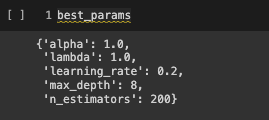


In [ ]:
best_params = {'alpha': 1.0,
               'lamda': 1.0,
               'learning_rate': 0.2,
               'max_depth': 8,
               'n_estimators': 200}

# Train the final XGBoost model with optimal hyperparameters
final_xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    **best_params
)

final_xgb_model.fit(df_balanced_features, labels)

In [ ]:
# Evaluate this model on the training dataset via 10-fold cross-validation
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)
scores = cross_validate(final_xgb_model, df_balanced_features, labels, scoring = ('precision', 'recall', 'roc_auc'), cv = cv, n_jobs = -1)

print('Precision:', round(np.mean(scores['test_precision']), 3))
print('Recall:', round(np.mean(scores['test_recall']), 3))
print('ROC score:', round(np.mean(scores['test_roc_auc']), 3))

In [ ]:
# Saving the model as a file for testing hidden_data later
with open('final_xgb_model', 'wb') as files:
  pickle.dump(final_xgb_model, files)

## 4.2 Feature Importance and Output Analysis

In [ ]:
# Feature importance graph from XGBoost
from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (15, 10)
plot_importance(final_xgb_model)
plt.show()

From the above plot, we can see that there are 9 relatively important features in the model based on their F score. The top 3 most important features are `cust_duration_mths`, `n_months_last_bought_products`, and `current_age`.

However, while this plot tells us the absolute importance of these features, they do not tell us anything about the direction of importance. For example, are clients who have been with Singlife for a longer duration more or less likely to purchase a policy within the next 3 months?

To identify the direction of importance, we plotted the SHAP values for the model, which gives us directionality and thus much more interpretability.

That said, this plot is nonetheless still valuable as it tells us which variables are NOT important in influencing clients' propensity to purchase (such as client type), and should therefore not be the main focus for Singlife's client retention strategy.

In [ ]:
# Using SHAP to see the directionality for the different features
explainer = shap.TreeExplainer(final_xgb_model)
shap_values = explainer.shap_values(df_balanced_features)
shap.summary_plot(shap_values, df_balanced_features, max_display = 20)

This plot allows us to distill our findings into three key high-level insights, corresponding with the top 9 most important features identified previously:

1. The higher the annual income of the client, the less likely they are to buy a product in the near future.
2. Clients in smaller households are less likely to buy products in the near future.
3. Clients who consent to SMS and/or mail are less likely to buy products in the near future. This is counter-intuitive as clients who consent to SMS and/or mail are normally perceived to be more interested in the company's products.

It is however interesting to note that the top 3 most important features for the SHAP plot do not exactly correspond with the top 3 for the F score chart.

## 5.0 Conclusion and Recommendations

From our findings, we suggest two broad approaches for Singlife in their overall client retention strategy:

1. Effective client segmentation based on important characteristics should be the key priority for targeted engagement efforts. Here, we show that high-income clients, as well as clients in smaller households, are especially at risk of churning, and thus should be a focal demographic for engagement (for example, organising more frequent touchpoints & call-ups).
2. As clients who consent to SMS and/or email are less likely to buy products in the near future, this could imply that Singlife's communication efforts may be counterproductive. One potential reason could be the lack of personalisation in SMSes or emails, which may cause clients to perceive the messages as spam. Thus, Singlife should look into ways in which they can revamp their communications strategy and increase engagement with clients via such channels.

Ultimately, while our model attempts to predict clients' future purchase behaviour based on their characteristics and past behaviour, it does not take into account factors such as client sentiment and competitor analysis, which may be more important in elucidating overall client satisfaction. More work has to be done and more data should be collected to build upon this expansive dataset, which will lead to an even better-performing predictive model.

## Testing Hidden Data 

The `testing_hidden_data` function below will be used by the datathon organisers to evaluate our model on a hidden test dataset. The function carries out the necessary data pre-processing steps that were determined in the analysis section above, before importing our trained model and predicting labels on this test set. Model performance was evaluated based on precision and recall.

In [ ]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:

  # first, replace all NA values with NaN
  hidden_data = hidden_data.fillna(value = np.nan)

  # then, aggregate the ape, sumins, and prempaid columns
  metx = ['ape', 'sumins', 'prempaid']

  for i in metx:
    new_colname = i + '_total'
    rel_cols = [col for col, is_rel in zip(hidden_data.columns, [col.split('_')[0] == i for col in hidden_data.columns]) if is_rel]
    hidden_data[new_colname] = hidden_data[rel_cols].sum(axis = 1)
    hidden_data = hidden_data.drop(columns = rel_cols, axis = 1)

  # then, create cust_duration_mths and current_age columns
  hidden_data['cltdob_fix'] = pd.to_datetime(hidden_data['cltdob_fix'], errors = 'coerce')
  hidden_data['current_age'] = 2024 - hidden_data['cltdob_fix'].dt.year

  hidden_data = hidden_data[hidden_data["min_occ_date"] != "None"]
  hidden_data['min_occ_date'] = pd.to_datetime(hidden_data['min_occ_date'], format = '%Y-%m-%d', errors = 'coerce')
  today = datetime.today()
  hidden_data['cust_duration_mths'] = (today - hidden_data['min_occ_date']) // pd.Timedelta('30D')

  # then, drop dob and min_occ_date columns
  hidden_data = hidden_data.drop(columns = ['cltdob_fix', 'min_occ_date'], axis = 1)

  # then, create ctry_is_sg, clttype_is_p, and stat_flag_is_active columns
  hidden_data['ctry_is_sg'] = np.where(hidden_data['ctrycode_desc'] == 'Singapore', 1, 0)
  hidden_data['clttype_is_p'] = np.where(hidden_data['clttype'] == 'P', 1, 0)
  hidden_data['stat_flag_is_active'] = np.where(hidden_data['stat_flag'] == 'ACTIVE', 1, 0)

  # then, drop other columns
  cols_to_drop = ['clntnum', 'race_desc', 'ctrycode_desc', 'clttype', 'stat_flag', 'cltsex_fix', 'flg_is_borderline_standard', 'flg_is_revised_term',
                  'flg_has_health_claim', 'flg_has_life_claim', 'flg_with_preauthorisation', 'is_consent_to_email', 'is_dependent_in_at_least_1_policy',
                  'f_ever_declined_la', 'hh_20', 'pop_20', 'hh_size', 'flg_latest_being_cancel', 'recency_lapse', 'recency_cancel', 'tot_cancel_pols',
                  'f_hold_839f8a', 'f_hold_e22a6a', 'f_hold_d0adeb', 'f_hold_c4bda5', 'f_hold_ltc', 'f_hold_507c37', 'f_hold_gi', 'lapse_ape_ltc_1280bf',
                  'lapse_ape_grp_6fc3e6', 'lapse_ape_grp_de05ae', 'lapse_ape_inv_dcd836', 'lapse_ape_grp_945b5a', 'lapse_ape_grp_6a5788', 'lapse_ape_ltc_43b9d5',
                  'lapse_ape_grp_9cdedf', 'lapse_ape_lh_d0adeb', 'lapse_ape_grp_1581d7', 'lapse_ape_grp_22decf', 'lapse_ape_lh_507c37', 'lapse_ape_lh_839f8a',
                  'lapse_ape_inv_e9f316', 'lapse_ape_grp_caa6ff', 'lapse_ape_grp_fd3bfb', 'lapse_ape_lh_e22a6a', 'lapse_ape_grp_70e1dd', 'lapse_ape_grp_e04c3a',
                  'lapse_ape_grp_fe5fb8', 'lapse_ape_grp_94baec', 'lapse_ape_grp_e91421', 'lapse_ape_lh_f852af', 'lapse_ape_lh_947b15', 'lapse_ape_32c74c',
                  'n_months_since_lapse_ltc_1280bf', 'n_months_since_lapse_grp_6fc3e6', 'n_months_since_lapse_grp_de05ae', 'n_months_since_lapse_inv_dcd836',
                  'n_months_since_lapse_grp_945b5a', 'n_months_since_lapse_grp_6a5788', 'n_months_since_lapse_ltc_43b9d5', 'n_months_since_lapse_grp_9cdedf',
                  'n_months_since_lapse_lh_d0adeb', 'n_months_since_lapse_grp_1581d7', 'n_months_since_lapse_grp_22decf', 'n_months_since_lapse_lh_507c37',
                  'n_months_since_lapse_lh_839f8a', 'n_months_since_lapse_inv_e9f316', 'n_months_since_lapse_grp_caa6ff', 'n_months_since_lapse_grp_fd3bfb',
                  'n_months_since_lapse_lh_e22a6a', 'n_months_since_lapse_grp_70e1dd', 'n_months_since_lapse_grp_e04c3a', 'n_months_since_lapse_grp_fe5fb8',
                  'n_months_since_lapse_grp_94baec', 'n_months_since_lapse_grp_e91421', 'n_months_since_lapse_lh_f852af', 'n_months_since_lapse_lh_947b15',
                  'n_months_since_lapse_32c74c', 'f_ever_bought_e22a6a', 'f_ever_bought_d0adeb', 'f_ever_bought_c4bda5', 'n_months_last_bought_839f8a',
                  'n_months_last_bought_e22a6a', 'n_months_last_bought_d0adeb', 'n_months_last_bought_c4bda5', 'n_months_last_bought_ltc', 'n_months_last_bought_507c37',
                  'n_months_last_bought_gi', 'f_ever_bought_ltc_1280bf', 'f_ever_bought_grp_de05ae', 'f_ever_bought_inv_dcd836', 'f_ever_bought_grp_6a5788',
                  'f_ever_bought_ltc_43b9d5', 'f_ever_bought_lh_d0adeb', 'f_ever_bought_grp_22decf', 'f_ever_bought_inv_e9f316', 'f_ever_bought_lh_e22a6a',
                  'f_ever_bought_grp_e04c3a', 'f_ever_bought_grp_fe5fb8', 'f_ever_bought_grp_94baec', 'f_ever_bought_32c74c', 'n_months_last_bought_ltc_1280bf',
                  'n_months_last_bought_grp_6fc3e6', 'n_months_last_bought_grp_de05ae', 'n_months_last_bought_inv_dcd836', 'n_months_last_bought_grp_945b5a',
                  'n_months_last_bought_grp_6a5788', 'n_months_last_bought_ltc_43b9d5', 'n_months_last_bought_grp_9cdedf', 'n_months_last_bought_lh_d0adeb',
                  'n_months_last_bought_grp_1581d7', 'n_months_last_bought_grp_22decf', 'n_months_last_bought_lh_507c37', 'n_months_last_bought_lh_839f8a',
                  'n_months_last_bought_inv_e9f316', 'n_months_last_bought_grp_caa6ff', 'n_months_last_bought_grp_fd3bfb', 'n_months_last_bought_lh_e22a6a',
                  'n_months_last_bought_grp_70e1dd', 'n_months_last_bought_grp_e04c3a', 'n_months_last_bought_grp_fe5fb8', 'n_months_last_bought_grp_94baec',
                  'n_months_last_bought_grp_e91421', 'n_months_last_bought_lh_f852af', 'n_months_last_bought_lh_947b15', 'n_months_last_bought_32c74c',
                  'flg_affconnect_show_interest_ever', 'flg_affconnect_ready_to_buy_ever', 'flg_affconnect_lapse_ever', 'affcon_visit_days', 'n_months_since_visit_affcon',
                  'clmcon_visit_days', 'recency_clmcon', 'recency_clmcon_regis', 'hlthclaim_amt', 'recency_hlthclaim', 'hlthclaim_cnt_success', 'recency_hlthclaim_success',
                  'hlthclaim_cnt_unsuccess', 'recency_hlthclaim_unsuccess', 'flg_hlthclaim_839f8a_ever', 'recency_hlthclaim_839f8a', 'flg_hlthclaim_14cb37_ever',
                  'recency_hlthclaim_14cb37', 'giclaim_amt', 'recency_giclaim', 'giclaim_cnt_success', 'recency_giclaim_success', 'giclaim_cnt_unsuccess', 'recency_giclaim_unsuccess',
                  'flg_gi_claim_29d435_ever', 'flg_gi_claim_058815_ever', 'flg_gi_claim_42e115_ever', 'flg_gi_claim_856320_ever']

  hidden_data = hidden_data.drop(columns = cols_to_drop, axis = 1)

  # then, drop all rows with NAs except for those in hh_size_est and annual_income_est
  ordinal_cols = ['hh_size_est', 'annual_income_est']
  hidden_data = hidden_data.dropna(subset=[col for col in hidden_data.columns if col not in ordinal_cols])

  # then, label encode hh_size_est and annual_income_est
  oe = OrdinalEncoder()
  hidden_data[ordinal_cols] = oe.fit_transform(hidden_data[ordinal_cols])

  # then, impute hh_size_est and annual_income_est w KNNImputer
  knn_imputer = KNNImputer(n_neighbors=5)
  hidden_data[ordinal_cols] = knn_imputer.fit_transform(hidden_data[ordinal_cols])
  hidden_data[ordinal_cols] = hidden_data[ordinal_cols].round()

  # then, convert all variables to numeric
  hidden_data = hidden_data.apply(pd.to_numeric, downcast = 'integer')
  numeric_columns = hidden_data.select_dtypes(include = 'number').columns
  hidden_data[numeric_columns] = hidden_data[numeric_columns].astype('int64', errors = 'ignore')

  # then, normalise continuous variables in dataset
  scaler = StandardScaler()
  continuous_cols = [x for x in hidden_data.columns if getattr(hidden_data, x).max() > 10]
  hidden_data[continuous_cols] = scaler.fit_transform(hidden_data[continuous_cols])

  # then, use tuned model above to predict test data
  hidden_data = hidden_data[df_balanced_features.columns]  # to ensure that the order of columns are the same between the training dataset and test dataset
  with open('final_xgb_model', 'rb') as f:                 # load model that was trained on training dataset
    final_xgb_model = pickle.load(f)

  predictions = final_xgb_model.predict(hidden_data)

  # finally, return list of predictions
  return list(predictions)

##### Cell to check testing_hidden_data function

In [ ]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))